In [203]:
import pandas as pd
from data_loader import *
from Snowball import *
import matplotlib.pyplot as plt
from WindPy import w


In [204]:
def backtest(snowball, index_data_all):
    """
    Perform backtest on a snowball product
    """
    # Process the backtest using historical index data
    snowball.process_backtest(index_data_all)

    # Compile the backtest results into a pandas Series
    result_series = pd.Series(
        (
            snowball.time_dynamic_param["start_date"],
            snowball.start_price,
            snowball.time_dynamic_param["end_date"],
            snowball.end_price,
            snowball.knockin_date,
            snowball.knockin_price,
            snowball.knockout_date,
            snowball.knockout_price,
            snowball.status,
            snowball.terminal_month,
            snowball.abs_return,
            snowball.annual_return,
            snowball.maturity_sign,
        )
    )
    return result_series


######################################################################################
# ---------------------------- Set Snowball parameters ------------------------------#
# 挂钩标的
underlying = "中证500"

# 价格数据
data_fields = ["close"]

# Snowball
snowball_type = "经典雪球"  # 经典雪球/降敲型雪球/限亏型雪球/限亏止盈型雪球/早利型雪球

# 合约期限
option_expire_month = 24

# 合约开始日期
start_date = pd.to_datetime("2016-11-22").date()

# 合约结束日期
end_date = ensure_trading_day(start_date + relativedelta(months=option_expire_month))

# 敲入条件
knockin_barrier = 0.75

# 敲出条件
knockout_barrier = 1
knockout_freq_month = 1

# 票息设置
kickout_coupon = 0.25
regular_coupon = 0.25

# 首个敲出观察日为距离观察起始日后的第x月
observation_start_month = 4

# 追保设置
margin_call = False  # 不允许追保

# ---------------------------- Generate Snowball param dicts ------------------------------#
# 生成固定配置
time_fixed_param = {"option_expire_month": option_expire_month}
time_dynamic_param = {"start_date": start_date, "end_date": end_date}
knockin_param = {"knockin_barrier": knockin_barrier}
knockout_param = {
    "observation_start_month": observation_start_month,
    "knockout_barrier": knockout_barrier,
    "knockout_freq_month": knockout_freq_month,
}
coupon_param = {"kickout_coupon": kickout_coupon, "regular_coupon": regular_coupon}
profit_param = {"margin_call": margin_call}

# ---------------------------- Initialize Snowball object ------------------------------#
# 初始化雪球类
snowball = SnowballOption.create_snowball(
    snowball_type,
    underlying,
    time_fixed_param,
    knockin_param,
    knockout_param,
    coupon_param,
    profit_param,
)
snowball.set_time_param(time_dynamic_param)

# -------------------------------------- Backtest ------------------------------#
# 获取标的价格信息
date_fields = ["close"]
index_data_all = get_underlying_data(
    underlying=underlying,
    data_fields=["close"],
    start_date=start_date,
    end_date=end_date,
    data_source="wind"
)

snowball_info = pd.DataFrame(backtest(snowball, index_data_all))
snowball_info.index = [
    "start_date",
    "start_price",
    "end_date",
    "end_price",
    "knockin_date",
    "knockin_price",
    "knockout_date",
    "knockout_price",
    "status",
    "terminal_month",
    "absolute_return",
    "annualized_return",
    "full_cycle",
]
snowball_info = snowball_info.to_dict()[0]


In [244]:
######################################################################################
# ---------------------------- etf ------------------------------#
# Set risk free rate
r_free = 0.025
r_free_daily = r_free / 365

# Set transaction cost
transaction_cost_etf = 2e-4
transaction_cost_futures = 3e-4

# Read delta grid
file_name = "case3_new_r0.025_q0.045_vol0.17_理论年化票息11.06%"
delta_grid = pd.read_excel(f"delta_grid/{file_name}.xlsx", index_col=0)
delta_grid.columns = delta_grid.columns.map(lambda x: pd.to_datetime(x).date())
delta_grid = delta_grid.map(lambda x: float(x.strip('%')) / 100)
delta_grid.index = delta_grid.index.map(lambda x: float(x.strip('%')) / 100)

if snowball_info["knockout_date"] == pd.to_datetime("1900-01-01").date():
    snowball_end_date = min(snowball.time_dynamic_param['end_date'],
                            last_trading_day(datetime.now().date()))
else:
    snowball_end_date = snowball_info["knockout_date"]

# Get index price data
index_price = get_underlying_data(
    underlying=underlying,
    data_fields=data_fields,
    start_date=start_date,
    end_date=snowball_end_date,
    data_source="wind",
)
index_price_pct = index_price["close"] / index_price.loc[start_date, "close"]

# Match fuures daily trading amount according to delta_grid
match_index = index_price_pct.apply(
    lambda x: delta_grid.index[
        min(range(len(delta_grid.index)), key=lambda i: abs(delta_grid.index[i] - x))
    ]
)

futures_amount_series = pd.Series([
    delta_grid.loc[match_index.iloc[i], match_index.index[i]]
    for i in range(match_index.shape[0])
], index=match_index.index)
futures_amount_series[futures_amount_series>1] = 1 # max hedge
futures_amount_series[futures_amount_series<0] = 0 # min hedge

In [245]:
#---------------------------------------------------------
# get corresponding contract ID during the period
end_date = snowball_info['end_date']

contract_list = []
for year in range(int(str(start_date.year)[2:]), int(str(snowball_end_date.year)[2:])+1):
    if year == int(str(start_date.year)[2:]):
        for month in range(int(str(start_date.month))-1, 13):
            contract = "IC" + str(year) + str(month).zfill(2) + ".CFE"
            contract_list.append(contract)
    elif year == int(str(snowball_end_date.year)[2:]):
        for month in range(1, int(str(end_date.month))+2):
            contract = "IC" + str(year) + str(month).zfill(2) + ".CFE"
            contract_list.append(contract)
    else:
        for month in range(1, 13):
            contract = "IC" + str(year) + str(month).zfill(2) + ".CFE"
            contract_list.append(contract)
            
# Loading all futures data
data_list = []
for contract in contract_list:
    contract_start = pd.to_datetime("20" + contract[2:6] + "01").date() - relativedelta(months=1)
    contract_end = pd.to_datetime("20" + contract[2:6] + "01").date() + relativedelta(months=1)
    data = w.wsd(contract, "close", datetime.strftime(contract_start, "%Y-%m-%d"), datetime.strftime(contract_end, "%Y-%m-%d"), "")
    df = pd.DataFrame(data.Data)
    df.columns = data.Times
    df.index = ['price']
    df = df.dropna(axis=1).T
    df['contract_ID'] = contract
    data_list.append(df)

contract_temp = pd.concat(data_list)
contract_temp = contract_temp[~contract_temp.index.duplicated(keep='first')]
contract_temp = contract_temp[(contract_temp.index>=start_date)&(contract_temp.index<=end_date)].copy()

# futures adjust position date: last date
adjust_datelist = []
for contract in contract_temp['contract_ID'].unique():
    temp = contract_temp[contract_temp['contract_ID']==contract].copy().sort_index()
    adjust_date = temp.index[-1]
    adjust_datelist.append(adjust_date)

In [246]:
# Now adjust date has two contract price data
contract_all = contract_temp[~contract_temp.index.isin(adjust_datelist)]
adjust_date_df = pd.concat(data_list).loc[adjust_datelist]
contract_all = pd.concat([contract_all, adjust_date_df]).sort_index()

# calculate reuturn group by each contract
contract_return = contract_all.groupby("contract_ID").apply(lambda x: x / x.shift(1) - 1)
contract_return = pd.DataFrame(contract_return).reset_index(drop=False)
contract_return.columns = ['contract_ID', 'date', 'return']
contract_return = contract_return.set_index('date')

# drop the new contract return data on adjust date
contract_return = contract_return.dropna(axis=0)

# drop duplicates for contract all, keep the last price
contract_all = contract_all[~contract_all.index.duplicated(keep='first')]


In [247]:
# Calculate index daily return
etf_price = get_underlying_data(
    underlying="中证1000-ETF",
    data_fields=data_fields,
    start_date=start_date,
    end_date=snowball_end_date,
    data_source="wind",
)
# etf_price = index_price.copy()
etf_return = etf_price / etf_price.shift(1) - 1
etf_return.columns = ['return']

In [259]:
# Calculate daily net value
datelist = get_trading_days_between(
    snowball_info["start_date"], snowball_end_date
)

value_per_point = 200
deposit_ratio = 0.3
initial_value = 1e8

net_value_df = pd.DataFrame(index=datelist, columns=["contract_num", "contract_price", "contract_amount", "deposit_amount", "etf_amount", "risk_free_amount", "net_value"])
net_value_df.loc[datelist[0], "net_value"] = initial_value
futures_amount_real = initial_value * futures_amount_series

last_net_value = initial_value

for i in range(len(datelist)):
    current_date = datelist[i]
    futures_target = futures_amount_real.loc[current_date]
    contract_price = value_per_point * contract_all.loc[current_date, "price"]

    contract_num = futures_target // contract_price
    etf_amount = futures_target % contract_price
    contract_amount = contract_num * contract_price
    deposit_amount = contract_amount * deposit_ratio
    risk_free_amount = last_net_value - etf_amount - contract_amount

    net_value_df.loc[current_date, "contract_num"] = contract_num
    net_value_df.loc[current_date, "contract_price"] = contract_price
    net_value_df.loc[current_date, "contract_amount"] = contract_amount
    net_value_df.loc[current_date, "etf_amount"] = etf_amount
    net_value_df.loc[current_date, "deposit_amount"] = deposit_amount
    net_value_df.loc[current_date, "risk_free_amount"] = risk_free_amount

    if i != len(datelist)-1:
        next_date = datelist[i+1]
        net_value_contract = contract_amount * (1+contract_return.loc[next_date, "return"])
        net_value_etf = etf_amount * (1+etf_return.loc[next_date, "return"])
        net_value_rf = risk_free_amount * (1+ r_free_daily)
        net_value = net_value_contract + net_value_etf + net_value_rf

        # Transaction cost - etf
        if i == 0:
            last_eft_amount = 0
        else:
            last_eft_amount = net_value_df.loc[datelist[i-1], "etf_amount"]
        etf_cost = abs(etf_amount - last_eft_amount) * transaction_cost_etf
        
        # Transaction cost - futures
        if i == 0: 
            last_contract_num = 0
        elif current_date in adjust_datelist:
            last_contract_num = -net_value_df.loc[datelist[i-1], "contract_num"]
        else:
            last_contract_num = net_value_df.loc[datelist[i-1], "contract_num"]
        contract_cost = abs(contract_num - last_contract_num) * contract_price * transaction_cost_futures

        net_value = net_value - etf_cost - contract_cost
        net_value_df.loc[next_date, "net_value"] = net_value
    

In [261]:
net_value_strategy = pd.DataFrame(net_value_df["net_value"]/initial_value, columns=['date', 'net_value']).set_index('date')
net_value_index = pd.DataFrame(index_price['close'] / index_price.loc[start_date, 'close'])
net_value_index.columns = ['net_value']

In [6]:
file_name

'情景3_r0.025_q0.045_vol0.17_理论年化票息11.06%'

In [7]:
case_num = 3
r = 0.025
q = 0.045
c = 0.1106
vol = 0.17

In [8]:
net_value_df = pd.DataFrame(index=net_value_strategy.index)
net_value_df['strategy'] = net_value_strategy['net_value']
net_value_df['index'] = net_value_index['net_value']
net_value_df['position'] = etf_amount_series.values

C:\Users\FEFE\AppData\Local\Temp\ipykernel_26192\3115455202.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


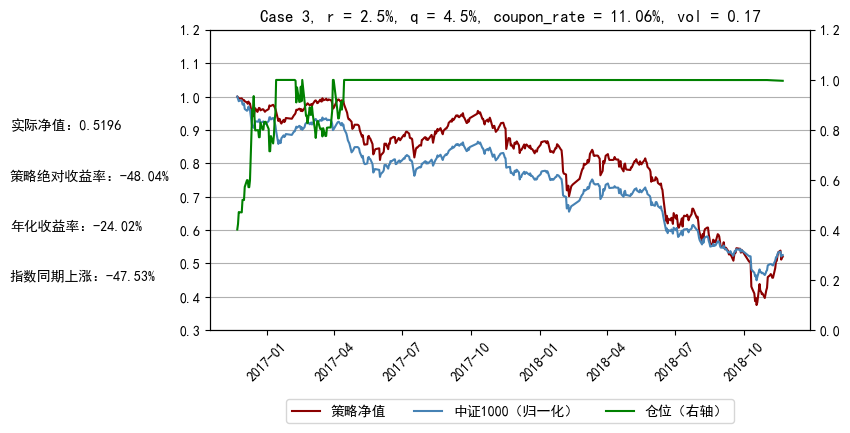

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(net_value_strategy, color="darkred", label="策略净值")
ax1.plot(net_value_index, color="steelblue", label="中证1000（归一化）")
# ax1.set_ylim(0.9, 1.2)
ax1.set_ylim(0.3, 1.2)
# ax1.set_ylim(0.5, 1.4) # case 5
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(etf_amount_series, color="green", label="仓位（右轴）")
# ax2.set_ylim(0, 1) # case 1
ax2.set_ylim(0, 1.2)
# ax2.set_ylim(-0.2, 1.2) # case 5
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0), ncol=3)

days_between = (net_value_strategy.index[-1] - net_value_strategy.index[0]).days
absolute_return = (net_value_strategy['net_value'].iloc[-1] /
                     net_value_strategy['net_value'].iloc[0] -
                     1)
annualized_return = absolute_return / days_between * 365

plt.text(0, 0.6, f"实际净值：{round(net_value_strategy['net_value'].iloc[-1], 4)}", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.5, f"策略绝对收益率：{round(absolute_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.4, f"年化收益率：{round(annualized_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(
    0,
    0.3,
    f"指数同期上涨：{round((net_value_index['net_value'].iloc[-1]/net_value_index['net_value'].iloc[0]-1)*100, 2)}%",
    fontsize=10,
    transform=plt.gcf().transFigure)
plt.title(
    f"Case {case_num}, r = {round(r*100, 2)}%, q = {round(q*100, 2)}%, coupon_rate = {round(c*100, 2)}%, vol = {vol}"
)
# plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.savefig(f"output_plot/Case{case_num}_r{r}_q{q}_vol{vol}.png", bbox_inches = 'tight')
plt.show()

net_value_df.to_csv(f"output_csv/Case{case_num}_r{r}_q{q}_vol{vol}.csv")

In [16]:
net1 = net_value_strategy[net_value_strategy.index>pd.to_datetime("2018-10-01").date()].copy()
net1['net_value'] = net1['net_value'] / net1['net_value'][0]
net2 = net_value_index[net_value_index.index>pd.to_datetime("2018-10-01").date()].copy()
net2['net_value'] = net2['net_value'] / net2['net_value'][0]


C:\Users\FEFE\AppData\Local\Temp\ipykernel_26192\1469661355.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  net1['net_value'] = net1['net_value'] / net1['net_value'][0]
C:\Users\FEFE\AppData\Local\Temp\ipykernel_26192\1469661355.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  net2['net_value'] = net2['net_value'] / net2['net_value'][0]


In [20]:
etf_amount_series[etf_amount_series.index>pd.to_datetime("2018-10-01").date()]

2018-10-08    1.0000
2018-10-09    1.0000
2018-10-10    1.0000
2018-10-11    1.0000
2018-10-12    1.0000
2018-10-15    1.0000
2018-10-16    1.0000
2018-10-17    1.0000
2018-10-18    1.0000
2018-10-19    1.0000
2018-10-22    1.0000
2018-10-23    1.0000
2018-10-24    1.0000
2018-10-25    1.0000
2018-10-26    1.0000
2018-10-29    1.0000
2018-10-30    1.0000
2018-10-31    0.9998
2018-11-01    0.9996
2018-11-02    0.9994
2018-11-05    0.9992
2018-11-06    0.9990
2018-11-07    0.9988
2018-11-08    0.9986
2018-11-09    0.9984
2018-11-12    0.9982
2018-11-13    0.9980
2018-11-14    0.9978
2018-11-15    0.9976
2018-11-16    0.9974
2018-11-19    0.9972
2018-11-20    0.9970
2018-11-21    0.9968
2018-11-22    0.9966
dtype: float64

In [19]:
pd.concat([net1,net2],axis=1)

,net_value,net_value
2018-10-08,1.000000,1.000000
2018-10-09,0.999933,1.000270
2018-10-10,0.996428,0.998961
2018-10-11,0.851723,0.925100
2018-10-12,0.840501,0.919095
2018-10-15,0.810534,0.904811
2018-10-16,0.764933,0.884532
2018-10-17,0.784263,0.890972
2018-10-18,0.741887,0.861339
2018-10-19,0.757517,0.880393


In [12]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(net_value_strategy, color="darkred", label="策略净值")
ax1.plot(net_value_index, color="steelblue", label="中证1000（归一化）")
# ax1.set_ylim(0.9, 1.2)
ax1.set_ylim(0.3, 1.2)
# ax1.set_ylim(0.5, 1.4) # case 5
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(etf_amount_series, color="green", label="仓位（右轴）")
# ax2.set_ylim(0, 1) # case 1
ax2.set_ylim(0, 1.2)
# ax2.set_ylim(-0.2, 1.2) # case 5
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0), ncol=3)

days_between = (net_value_strategy.index[-1] - net_value_strategy.index[0]).days
absolute_return = (net_value_strategy['net_value'].iloc[-1] /
                     net_value_strategy['net_value'].iloc[0] -
                     1)
annualized_return = absolute_return / days_between * 365

plt.text(0, 0.6, f"实际净值：{round(net_value_strategy['net_value'].iloc[-1], 4)}", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.5, f"策略绝对收益率：{round(absolute_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.4, f"年化收益率：{round(annualized_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(
    0,
    0.3,
    f"指数同期上涨：{round((net_value_index['net_value'].iloc[-1]/net_value_index['net_value'].iloc[0]-1)*100, 2)}%",
    fontsize=10,
    transform=plt.gcf().transFigure)
plt.title(
    f"Case {case_num}, r = {round(r*100, 2)}%, q = {round(q*100, 2)}%, coupon_rate = {round(c*100, 2)}%, vol = {vol}"
)
# plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.savefig(f"output_plot/Case{case_num}_r{r}_q{q}_vol{vol}.png", bbox_inches = 'tight')
plt.show()

net_value_df.to_csv(f"output_csv/Case{case_num}_r{r}_q{q}_vol{vol}.csv")

2016-11-22    0.4018
2016-11-23    0.4241
2016-11-24    0.4715
2016-11-25    0.4709
2016-11-28    0.4703
               ...  
2018-11-16    0.9974
2018-11-19    0.9972
2018-11-20    0.9970
2018-11-21    0.9968
2018-11-22    0.9966
Length: 490, dtype: float64

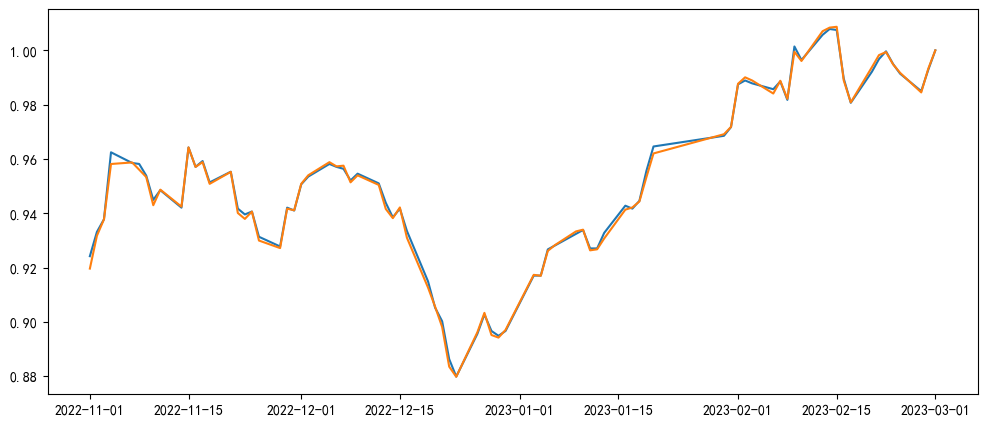

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(etf_price/etf_price.iloc[-1])
plt.plot(index_price/index_price.iloc[-1])